In [1]:
### Load libraries ###

# interactive plotting
#%matplotlib inline
#%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Machine learning libraries
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from statsmodels.tsa.stattools import adfuller

from sklearn.neural_network import MLPRegressor
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Machine Learning libraries
from statsmodels.tsa.seasonal import seasonal_decompose, STL


from sklearn import set_config
set_config(display='diagram')
plt.rcParams.update({'figure.figsize': (8, 5), 'figure.dpi': 120})


# MLTOOLS - Custom library
from mltools import regression_tools as RT
from mltools import forecast_tools as FT
from mltools import model_tools as MT
from neuralsens import partial_derivatives as ns
import scipy as sp

# Statsmodels time series 
#from statsmodels.tsa import SARIMAX
import statsmodels.api as sm

# Datetime for managing dates
from datetime import datetime
import scipy.stats as st

C:\Users\Enrique\anaconda3\envs\ml\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


torch installation could not be found, only numpy activation functions allowed


---
## 1. Read the dataset

Indicamos que la variable date tiene fechas (parse_dates), para decirle que no es una variable mas sino que es un indice de fechas. 

Al leer el df, no lo configuramos como una variable más sino como un indice. 

In [2]:
# Import data
dateparse = lambda x :datetime.strptime(x ,"%d/%m/%Y")

df = pd.read_csv('UnemploymentSpain.dat',sep='\t', parse_dates=['DATE'], dayfirst=True, date_parser=dateparse, index_col='DATE')

df.head()

,TOTAL
DATE,
2001-01-01,2017389
2001-02-01,1993273
2001-03-01,1981006
2001-04-01,1910453
2001-05-01,1898285


In [3]:
df.shape

(262, 1)

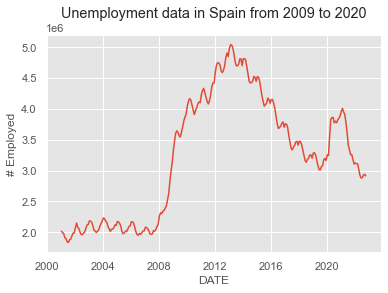

In [4]:
# Plotting a time series
fig, ax = plt.subplots()
ax.plot('TOTAL', data=df)
ax.set(title='Unemployment data in Spain from 2009 to 2020', xlabel='DATE', ylabel='# Employed')
plt.show()

Vemos que no hay constancia ni en la media ni en la varianza, por lo que deberemos estabilizarlas.

Viendo esta serie, aun no puedo saber si es autorregresiva, ruido blanco o lo que sea.

In [5]:
df_unemployment = df[['TOTAL']] # Maintain data.frame format for column
df_unemployment

,TOTAL
DATE,
2001-01-01,2017389
2001-02-01,1993273
2001-03-01,1981006
2001-04-01,1910453
2001-05-01,1898285
...,...
2022-06-01,2880582
2022-07-01,2883812
2022-08-01,2924240


<Figure size 432x288 with 0 Axes>

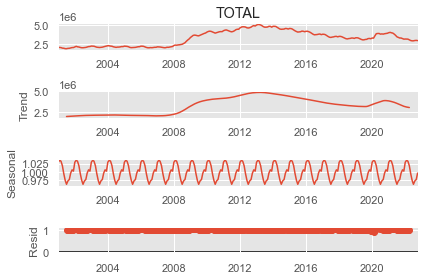

In [6]:
# Multplicative Decomposition
result_mul = seasonal_decompose(df_unemployment['TOTAL'], model='multiplicative')
plt.figure()
result_mul.plot()
plt.show()

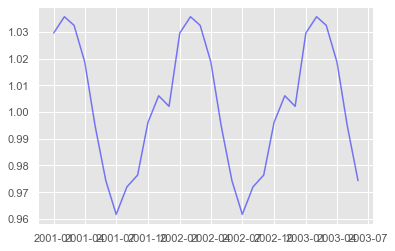

In [7]:
plt.plot(result_mul.seasonal[:30], color='blue', alpha=0.5, label='Multiplicative seasonal')


---
### Identification process

Con esta funcion, lo que estamos pintando es la serie original y las funciones de correlacion simple parcial (acf y pacf)

Los pasos a seguir son:
- 1. Identificacion (ACF yPACF)
- 2. Diagnostico
    
#### 1. Plot the series and search for possible outliers

En primer lugar pintamos la serie, viendo la correlacion vemos que tiene pinta de que la media no es estacionaria

Para comprobar la varianza, deberemos pintar Box Cox

C:\Users\Enrique\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


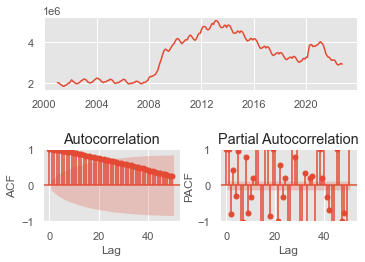

In [8]:
# ACF and PACF of the time series -> identify significant lags and order
FT.ts_display(df_unemployment,lags=50)

Para pintar la siguiente gráfica, en un primer momento no sabremos cómo establecer la estacionalidad. Pondremos un número aleatorio (que creamos que tenga sentido), y estabilizaremos la varianza con ese numero.

Una vez pintemos la diferenciacion estacional (tras ejecutar boxcox para estabilizar la varianza), podremos ver la tendencia que sigue la serie en el grafico de Autocorrelacion. Mirando los picos de ese gráfico, podemos sacar la estacionalidad.

Una vez averiguada la estacionalidad real de la serie, deberemos repetir el proceso de transformacion BoxCox, pero esta vez introduciendo la estacionalidad correcta averiguada.

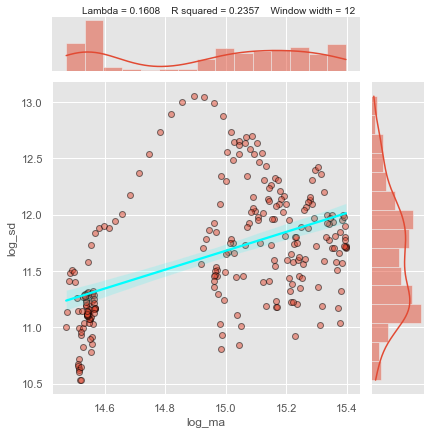

0.1607915855603168

In [9]:
FT.boxcox_lambda_plot(df_unemployment, window_width=12)

De la gráfica anterior podemos sacar el valor de lambda, que deberemos introducir en la funcion BoxCox para estabilizar la varianza

C:\Users\Enrique\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


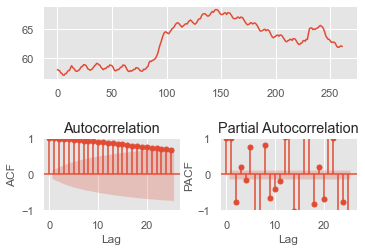

In [10]:
# Compute Box CoxPlot transformed data
BOX_COX = True
if BOX_COX:
    lmbda = 0.161 #Select lambda
    z = st.boxcox(df_unemployment.values[:,0],   lmbda = lmbda) #Convert series to positive if neccesary
    #z,lmbda = st.boxcox(df_ts.values[:,0] - min(df_ts.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=df_unemployment.columns.values.tolist())
else:
    z = df_unemployment

# Plot transformed data
FT.ts_display(z)

Una vez estabilizada la varianza, tengo que analizar la parte estacionaria. Si nos fijamos, vemos que claramente tenemos que diferenciar la media.

A continuacion, pintamos de nuevo la distribucion de la varianza. Vemos que ahora es una linea horizontal y que, además, el valor de lambda es muy cercano a 1. Esto nos indica que se ha estabilizado correctamente.

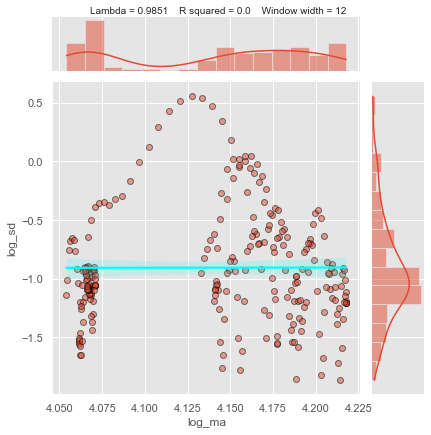

0.9850716550948463

In [11]:
#Check Box Cox of transformed series
FT.boxcox_lambda_plot(z, window_width=12)

#### 3. Analyze stationarity 

Vamos a aplicar el test Dickey Fuller para asegurarnos de que tenemos que diferenciar la media. Si obtenemos un pvalor mayor que 0.05, significará que debemos realizar al menos una diferenciacion.


In [12]:
# Alternative test - Augmented Dickey Fuller Test
# Aplicando este test, podemos saber si debemos realizar diferenciacion para la media o no. Si el pvalor es mayor de 0.05, se realiza diferenciacion
result = adfuller(z.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.644424
p-value: 0.459950
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573


Como el pvalor es mayor que 0.05, se realiza diferenciacion en la media. (d =1)

*Nota*: En primer lugar vemos que con D = 0, obtenemos un seasonality de 12 (hay un pico cada 12 puntos) Debemos hacer esto para establecer la seasonality. Lo hacemos con 0 para ver, y luego ya hacemos la transformacion boxcox con la seasonality que hayamos descubierto en este gráfico

`Diferenciacion en la media:`

C:\Users\Enrique\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


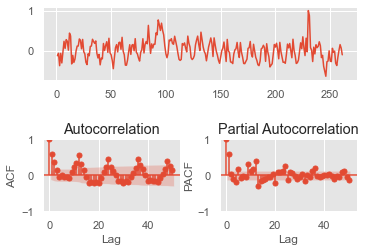

In [13]:
# Difference of the time series
d = 1 # diferenciacion regular. y(t)-y(t-q). Incremento respecto del instante anterior
D = 0 # Diferenciacion estacional. Voy a obtener una nueva serie que es y(t)- y(t-s). Incremento respecto del periodo anterior
S = 12 # Seasonality of 12 days

Bz = z
for diff in range(d):
    Bz = Bz.diff().dropna() # drop first NA value
for seas_diff in range(D):
    Bz = Bz.diff(S).dropna() # drop first NA values
FT.ts_display(Bz,lags=50)

Al hacer una diferenciacion de la media (d=1) vemos que se estabiliza (primer gráfico), pero la serie no es estacionaria igualmente, puesto que las autocorrelaciones no decrecen. Esto significa que debemos aumentar la correlacion estacional (D=1)

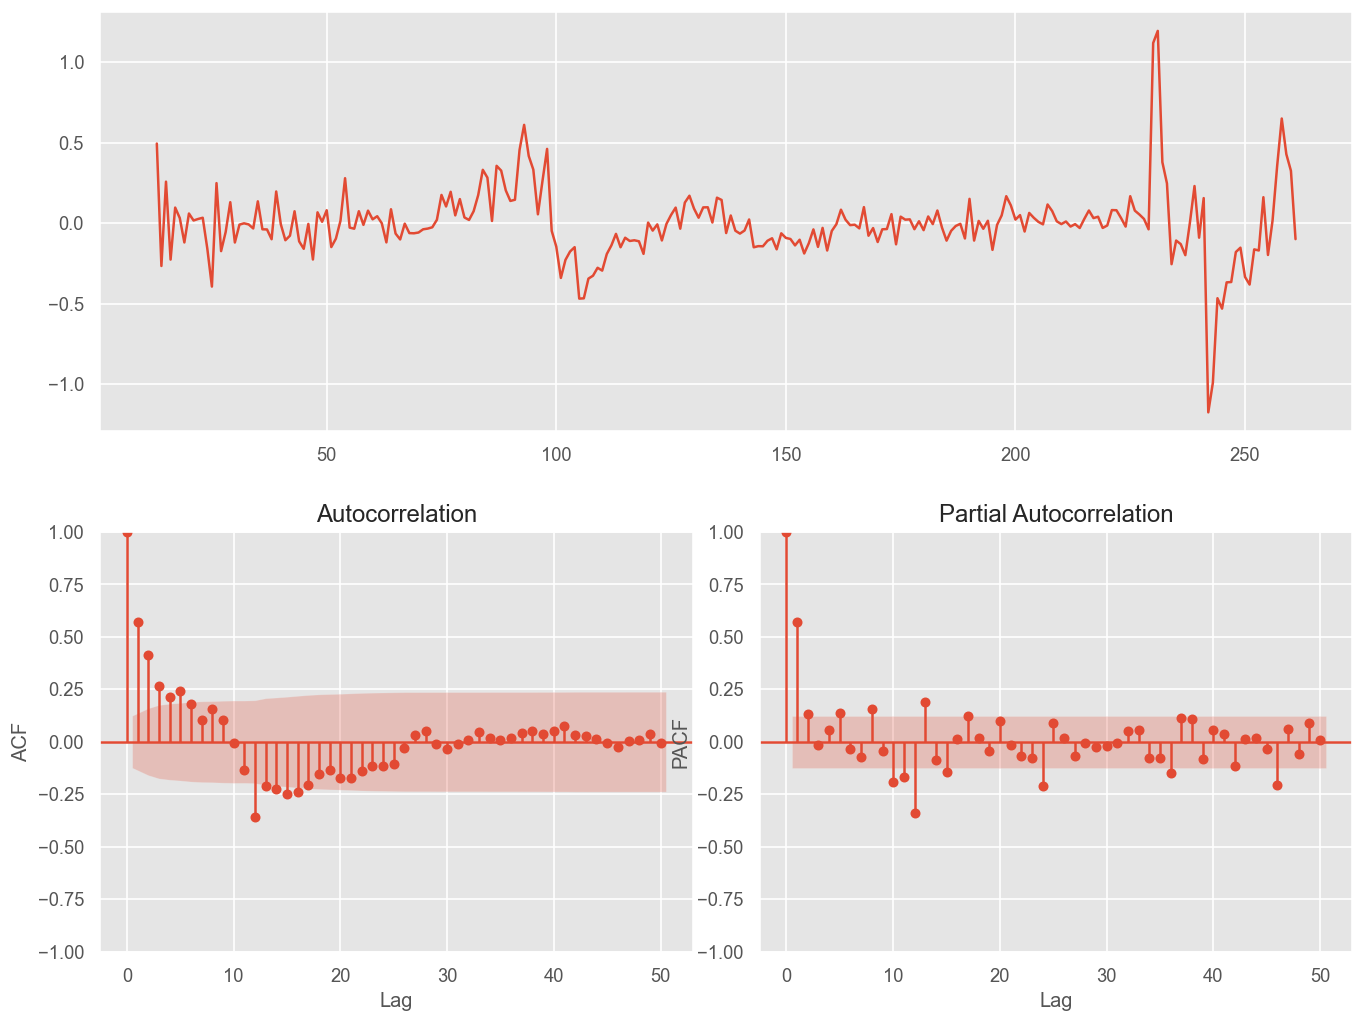

In [14]:
# Difference of the time series
d = 1 # diferenciacion regular. y(t)-y(t-q). Incremento respecto del instante anterior
D = 1 # Diferenciacion estacional. Voy a obtener una nueva serie que es y(t)- y(t-s). Incremento respecto del periodo anterior
S = 12 # Seasonality of 12 days

Bz = z
for diff in range(d):
    Bz = Bz.diff().dropna() # drop first NA value
for seas_diff in range(D):
    Bz = Bz.diff(S).dropna() # drop first NA values

plt.rcParams.update({'figure.figsize': (12, 9), 'figure.dpi': 120})
FT.ts_display(Bz,lags=50)

Como podemos ver en la gráfica anterior, una vez aumentada la correlacion estacional (D=1), vemos que tanto la tendencia estacional como la periodica está disminuyendo, por lo que ya tenemos la serie como queríamos y podemos empezar a ajustar el modelo de arima. 

#### 5. Fit SARIMA model and check significance of the coefficients

Vamos a analizar los gráficos de ACF y PACF obtenidos anteriormente para establecer los mejores parámetros para ajustar nuestro modelo.
- Fijandonos en la parte regular tenemos dos opciones:
    - ACF 3 o 4, lo que implica un MA de orden 3 (más simple)
    - PACF 1 o 2, lo que implica un AR de orden 1

    Empezaremos por probar el modelo más simple (AR de orden 1), para ver como se ajusta.


- Fijandonos en la parte estacional. (Barras localizadas en los multiplos de 12 (seasonality))
    - En primer lugar hemos comprobado que queremos diferenciar (para conseguir decrecer la autocorrelacion)
    - ACF de orden 1 (Una unica barra en el 12) --> MA de orden 1
    - PACF de orden 2 o 3 (Barras en 12, 24 y puede que 36) --> AR de orden 2
    - Seasonality de 12, como ya hemos visto

    Al igual que en la parte regular, comenzaremos probando el modelo más simple (MA de orden 1), para ver cómo se comportan las predicciones


In [15]:
# Fit model with estimated order
'''
AR --> (p) PACF
MA --> (q) ACF
Orden --> (p,d,q)
'''
sarima_fit = SARIMAX(z, 
                    order=(1,1,0), # Regular components (p,d,q) --> en el d ponemos un 1 porque hemos decidido diferenciar. AR(1)
                    seasonal_order=(0, 1, 1, 12),  # Seasonal components [P,D,Q,S] --> Estacionales - MA(1)
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=False, 
                    enforce_stationarity=False).fit()
sarima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                TOTAL   No. Observations:                  262
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 128.453
Date:                              Mon, 28 Nov 2022   AIC                           -250.905
Time:                                      21:28:57   BIC                           -240.514
Sample:                                           0   HQIC                          -246.716
                                              - 262                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6786      0.028     23.950      0.000       0.623       0.734
ma.S.L12      -0.8464      0.043    -19.570      0.000      -0.931      -0.762
sigma2         0.0190      0.001     33.578      0.000       0.018       0.020
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):              3864.99
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               2.15   Skew:                             2.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Ajustando el modelo vemos que los pvalores de todos los coeficientes son son 0, lo cual es buena señal. A su vez, obtenemos un AIC negativo.

C:\Users\Enrique\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  18.370189   0.826278


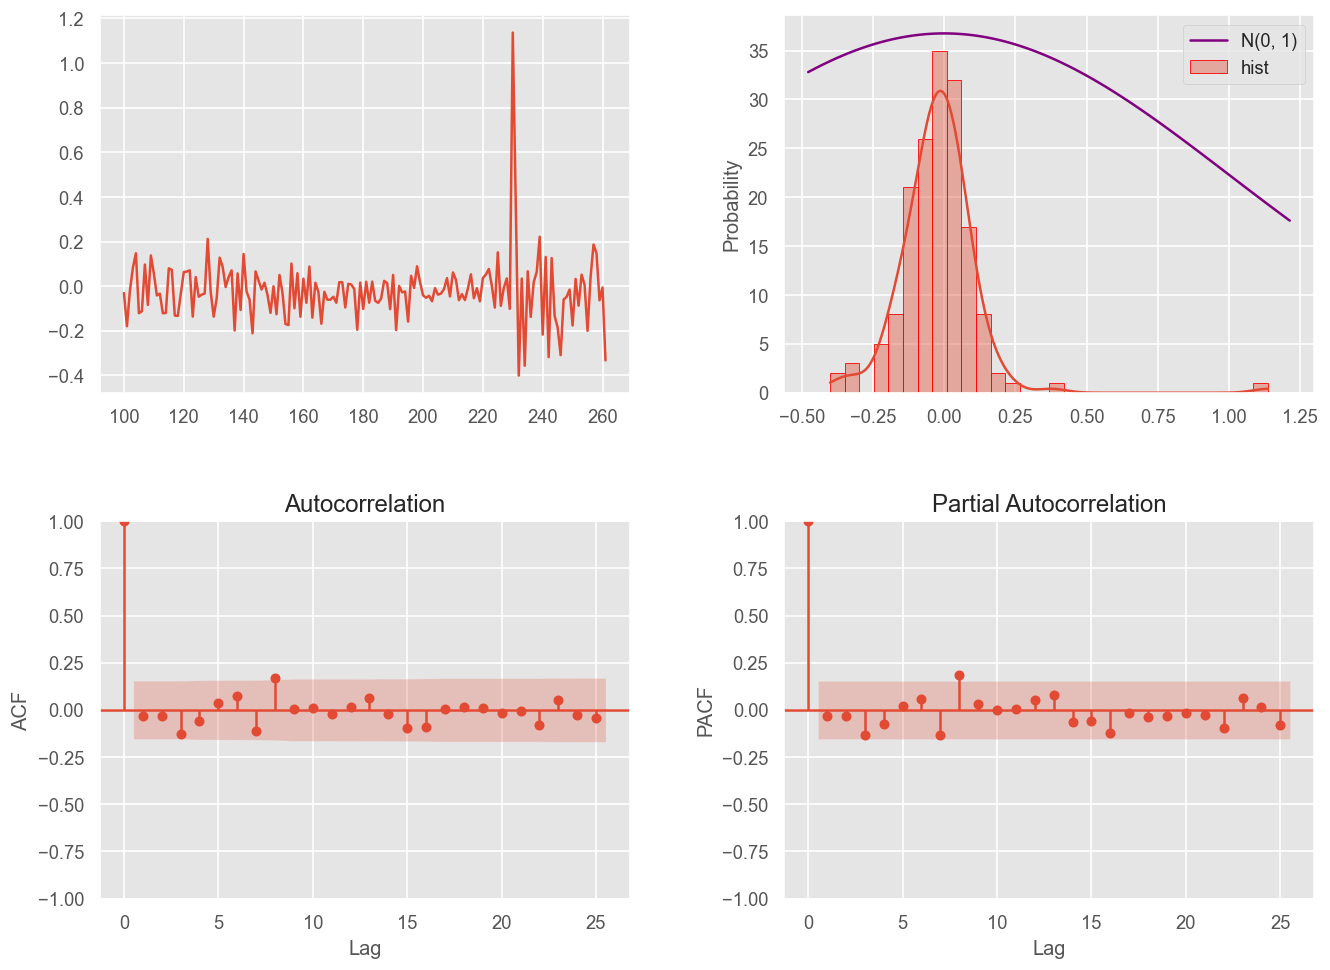

In [16]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit.resid.loc[100:]))

Al pintar los residuos vemos que prácticamente hemos obtenido ruido blanco (errores de mi modelo que asumo porque no soy capaz de modelar), por lo que deducimos que es un buen modelo.

A continuacion, vamos a realizar las predicciones para el mes que viene con el modelo que hemos entrenado.

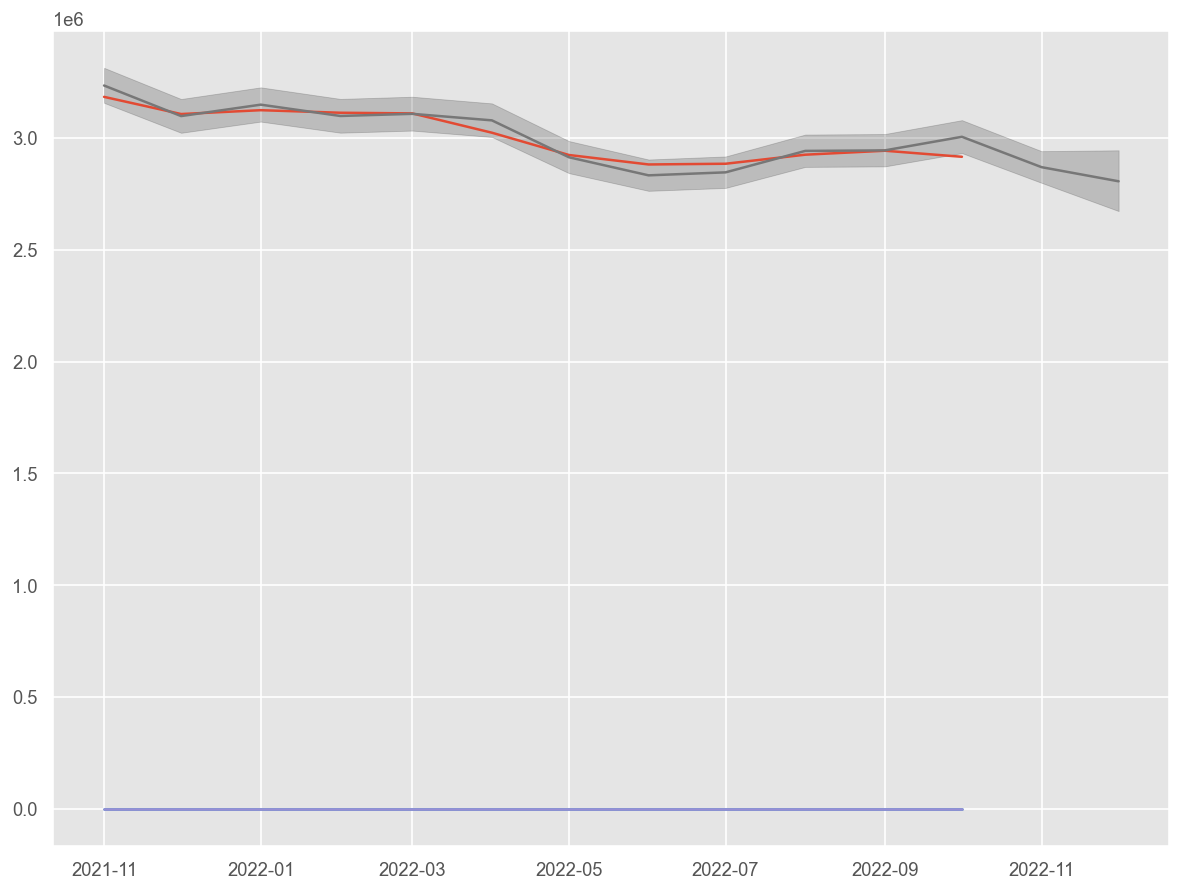

In [101]:
#Obtain forecasts for in-sample and out-of-sample
start = 250
horizon = 1 # El mes siguiente
end = df_unemployment["TOTAL"].shape[0] + horizon

pred = sarima_fit.get_prediction(start = start, end=end, dynamic=False)
print(pred)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

# Obtener las fechas de la prediccion (indice de fecha en nuestro df)
dates_to_plot = []
num_index = np.arange(start, end+1)
for i in range(0, len(num_index)):
    # Vamos añadiendo meses para pintar el indice de yhat
    d = df_unemployment.index[start] + pd.DateOffset(months=i)
    dates_to_plot.append(d)
yhat.index = dates_to_plot
yhat_conf_int.index = dates_to_plot

initial_date = df_unemployment.index[start]
plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(df_unemployment.loc[initial_date:, :])
plt.plot(yhat)

plt.show()

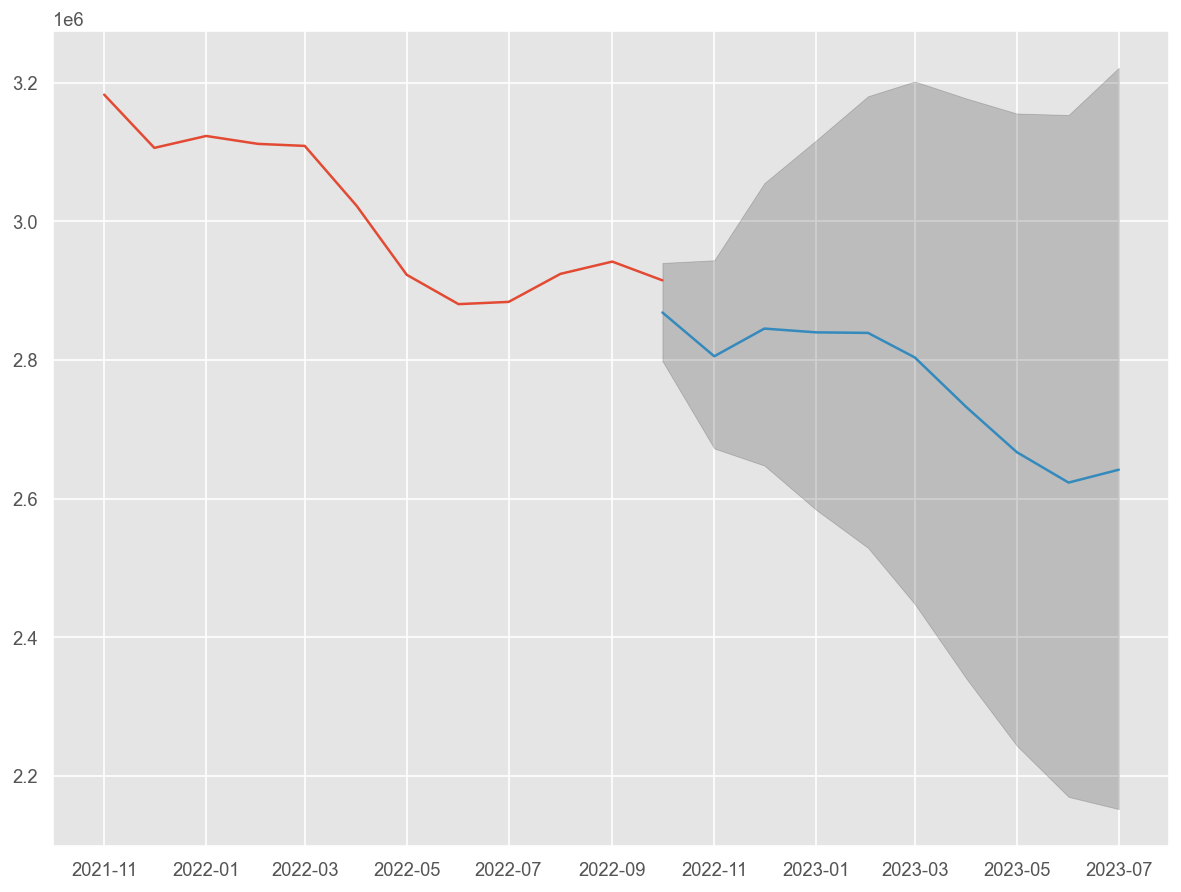

In [103]:
# Plot prediction of out_of_sample and confidence intervals
start = 250
horizon = 10 # El mes siguiente
end = df_unemployment["TOTAL"].shape[0] + horizon

pred = sarima_fit.get_forecast(steps=horizon, dynamic=False)
print(pred)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

# Obtener las fechas de la prediccion (indice de fecha en nuestro df)
dates_to_plot = []
num_index = np.arange(start, end+1)
for i in range(0, horizon):
    # Vamos añadiendo meses para pintar el indice de yhat
    d = df_unemployment.index[-1] + pd.DateOffset(months=i)
    dates_to_plot.append(d)

yhat.index = dates_to_plot
yhat_conf_int.index = dates_to_plot
initial_date = df_unemployment.index[start]
plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(df_unemployment["TOTAL"].loc[initial_date:])
plt.plot(yhat)
plt.show()

In [19]:
# Ahora podemos obtener el numero de personas que predice nuestro modelo 
num_parados_noviembre = yhat.loc["2022-11-01"]
num_parados_octubre = df_unemployment.loc["2022-10-01"]["TOTAL"]
print(f"El numero de parados en octubre fue de {num_parados_octubre} personas.")
print(f"Nuestro modelo predice que el numero de parados de noviembre de 2022 es de: {num_parados_noviembre} personas")

El numero de parados en octubre fue de 2914892 personas.
Nuestro modelo predice que el numero de parados de noviembre de 2022 es de: 2805381.9379022373 personas


In [20]:
df_unemployment

,TOTAL
DATE,
2001-01-01,2017389
2001-02-01,1993273
2001-03-01,1981006
2001-04-01,1910453
2001-05-01,1898285
...,...
2022-06-01,2880582
2022-07-01,2883812
2022-08-01,2924240


--- 
#### 5. Fit SARIMAX time series
---
##### 1. Preparing the dataset

In [21]:
linear_covid = np.arange(0,1,1/len(df_unemployment.loc["2020-03-01":]))
linear_covid = linear_covid[::-1]
linear_covid

array([0.96875, 0.9375 , 0.90625, 0.875  , 0.84375, 0.8125 , 0.78125,
       0.75   , 0.71875, 0.6875 , 0.65625, 0.625  , 0.59375, 0.5625 ,
       0.53125, 0.5    , 0.46875, 0.4375 , 0.40625, 0.375  , 0.34375,
       0.3125 , 0.28125, 0.25   , 0.21875, 0.1875 , 0.15625, 0.125  ,
       0.09375, 0.0625 , 0.03125, 0.     ])

In [22]:
uniform_covid = np.random.uniform(0, 1,size=len(df_unemployment.loc["2020-03-01":]))
uniform_covid = np.sort(uniform_covid) 
uniform_covid = uniform_covid[::-1]
# plt.plot(uniform_covid)

In [23]:
# vamos a añadir una columna nueva a nuestro dataframe, indicando con un 0 la epoca en la que no había covid y con un 1 en la que sí
# además, en el rango de fechas en el que si hay covid, vamos a generar una rampa (Decay), para darle más o menos peso al covid en 
# funcion de si estamos más o menos cerca de la cuarentena (Que, como hemos visto, provocó el pico maximo de paro de esas fechas)

# en concreto, vamos a generar dos columnas, una para un linear decay, en el que estaremos indciandole al modelo que el covid decrece linealmente
# y un exponential decay, en el que estaremos indicandole un decrecimiento exponencial de la importancia del covid, y compararemos ambos, para ver cuál se ajusta mejor

df_unemployment["COVID_L"] = 0

df_unemployment.loc["2020-03-01":, "COVID_L"] = linear_covid
df_unemployment

,TOTAL,COVID_L
DATE,,
2001-01-01,2017389,0.00000
2001-02-01,1993273,0.00000
2001-03-01,1981006,0.00000
2001-04-01,1910453,0.00000
2001-05-01,1898285,0.00000
...,...,...
2022-06-01,2880582,0.12500
2022-07-01,2883812,0.09375
2022-08-01,2924240,0.06250


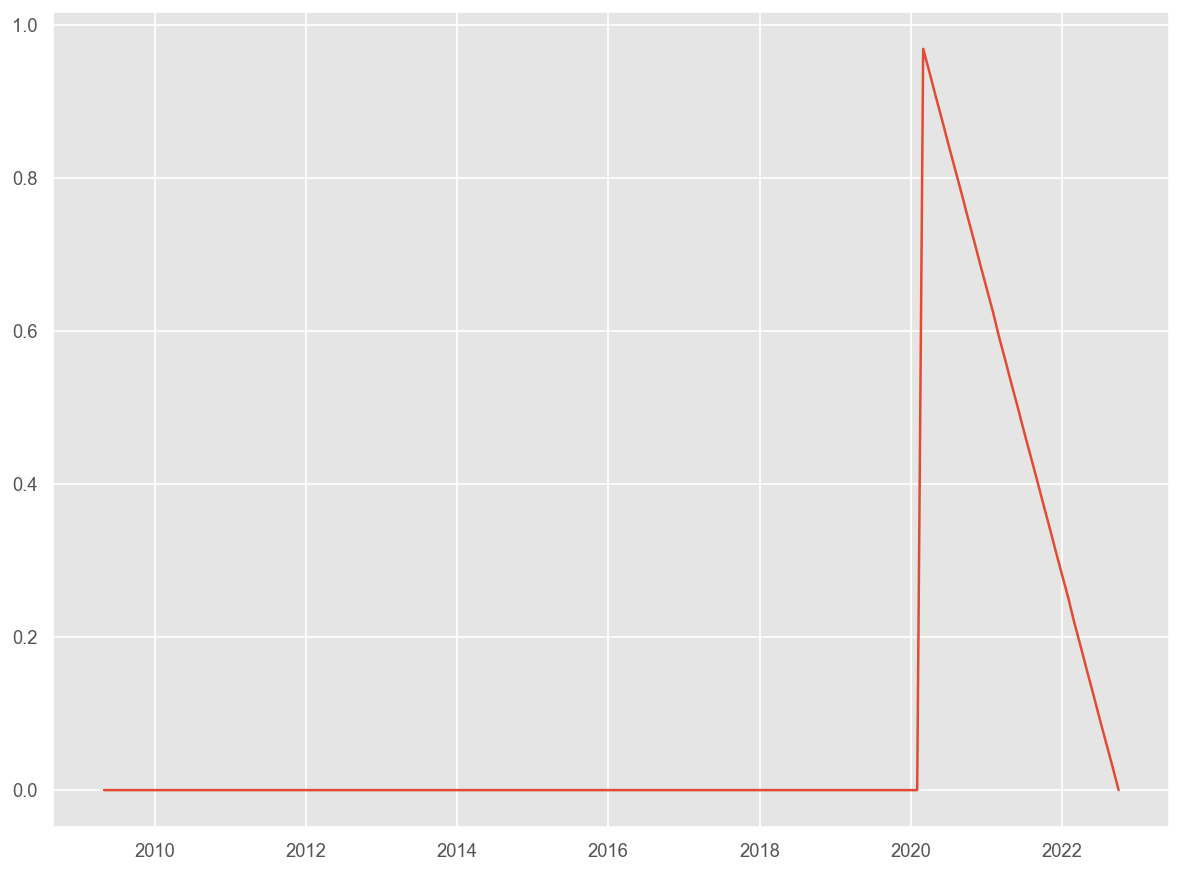

In [24]:
plt.plot(df_unemployment[100:]["COVID_L"])
plt.show()

In [25]:
df_unemployment['COVID_U'] = 0

df_unemployment.loc["2020-03-01":, "COVID_U"] = uniform_covid
df_unemployment

,TOTAL,COVID_L,COVID_U
DATE,,,
2001-01-01,2017389,0.00000,0.000000
2001-02-01,1993273,0.00000,0.000000
2001-03-01,1981006,0.00000,0.000000
2001-04-01,1910453,0.00000,0.000000
2001-05-01,1898285,0.00000,0.000000
...,...,...,...
2022-06-01,2880582,0.12500,0.169238
2022-07-01,2883812,0.09375,0.155486
2022-08-01,2924240,0.06250,0.121810


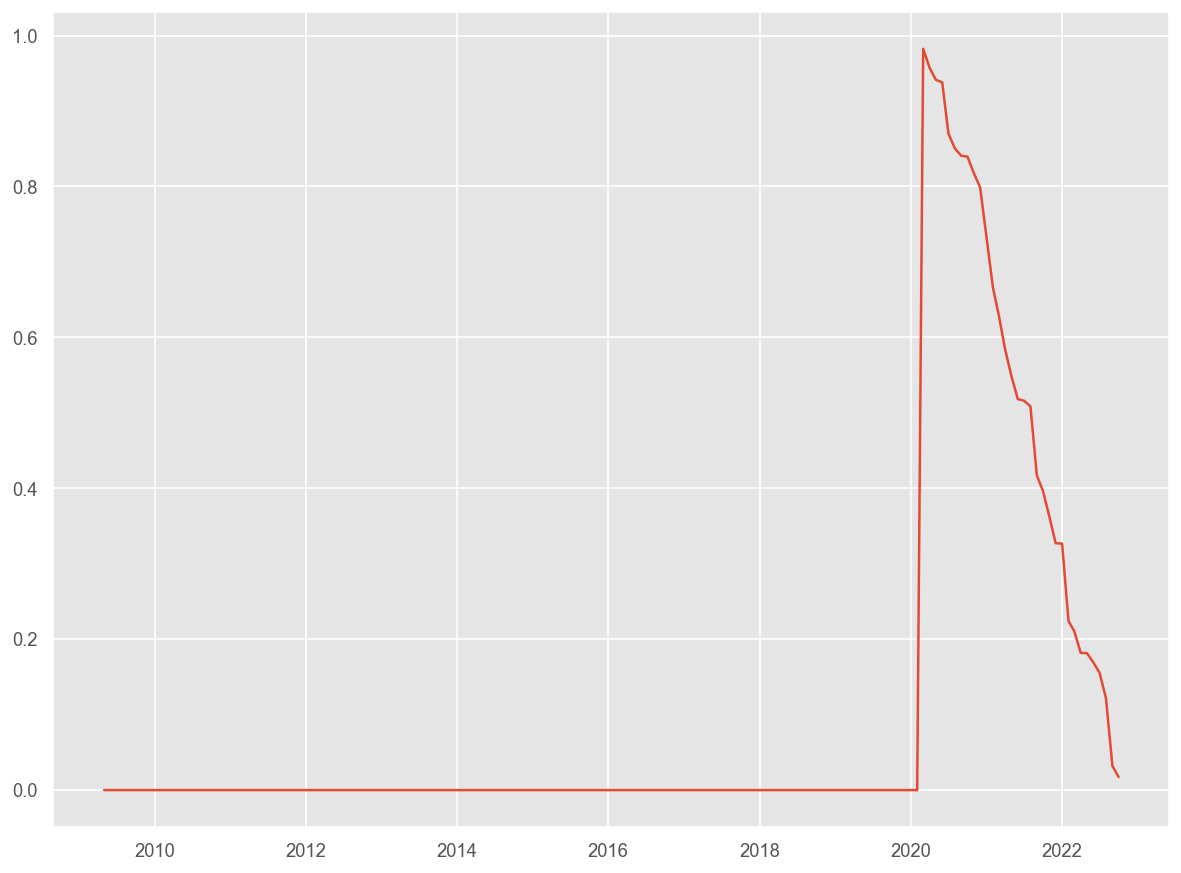

In [26]:
plt.plot(df_unemployment[100:]["COVID_U"])
plt.show()

In [27]:
df_unemployment_save = df_unemployment.copy()

In [28]:
df_unemployment = df_unemployment_save.copy()

In [29]:
# Define input and output matrices
INPUTS = ['COVID_L', 'COVID_U']
OUTPUT = 'TOTAL'

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = df_unemployment[INPUTS]
y = df_unemployment[OUTPUT]


Ahora, configuramos el modelo para que entrene con el set de datos de entrenamiento que hemos generado.

Establecemos los mismos ordenes (tanto regulares como de seasonality) que hemos seleccionado para el modelo de SARIMA 

In [30]:
# We could also fit a more complicated model with ARMA with seasonal components.
mod_sarimax = sm.tsa.SARIMAX(endog = y, 
                            trend = 'c',
                            order=(1,1,3), # Regular components (p,d,q)
                            seasonal_order=(1, 1, 1, 12),  # Seasonal components [P,D,Q,S] 
                            #  ORDEN DE SARIMA (anterior)
                            # order=(1,1,0), # Regular components (p,d,q) --> en el d ponemos un 1 porque hemos decidido diferenciar. AR(1)
                            # seasonal_order=(0, 1, 1, 12),  # Seasonal components [P,D,Q,S] --> Estacionales - MA(1)
                            exog = X,
                            enforce_invertibility=False, 
                            enforce_stationarity=False)
res_sarimax = mod_sarimax.fit()

# Show the summary of results
res_sarimax.summary()

C:\Users\Enrique\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Enrique\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                TOTAL   No. Observations:                  262
Model:             SARIMAX(1, 1, 3)x(1, 1, [1], 12)   Log Likelihood               -2826.429
Date:                              Mon, 28 Nov 2022   AIC                           5672.858
Time:                                      21:29:01   BIC                           5707.368
Sample:                                  01-01-2001   HQIC                          5686.774
                                       - 10-01-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -388.2859   1573.586     -0.247      0.805   -3472.458    2695.886
COVID_L    -2.492e+05   2.31e+05     -1.078      0.281   -7.03e+05    2.04e+05
COVID_U     5.849e+05   2.31e+05      2.531      0.011    1.32e+05    1.04e+06
ar.L1          0.8538      0.115      7.415      0.000       0.628       1.079
ma.L1         -0.3516      0.131     -2.689      0.007      -0.608      -0.095
ma.L2         -0.0958      0.108     -0.890      0.374      -0.307       0.115
ma.L3         -0.0878      0.075     -1.171      0.242      -0.235       0.059
ar.S.L12      -0.2189      0.061     -3.598      0.000      -0.338      -0.100
ma.S.L12      -0.1541      0.046     -3.320      0.001      -0.245      -0.063
sigma2      2.308e+09     49.819   4.63e+07      0.000    2.31e+09    2.31e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4766.02
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               3.70   Skew:                             2.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.17e+24. Standard errors may be unstable.
"""

Al pintar los residuos, podemos observar que obtenemos ruido blanco, lo que nos indica que nuestro modelo está ajustando correctamente

C:\Users\Enrique\anaconda3\envs\ml\lib\site-packages\mltools\forecast_tools.py:86: RuntimeWarning: invalid value encountered in divide
  y_pdf = y1 * y_pdf / np.max(y_pdf)
C:\Users\Enrique\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Ljung-Box test of residuals:
      lb_stat  lb_pvalue
50  37.391218   0.906181


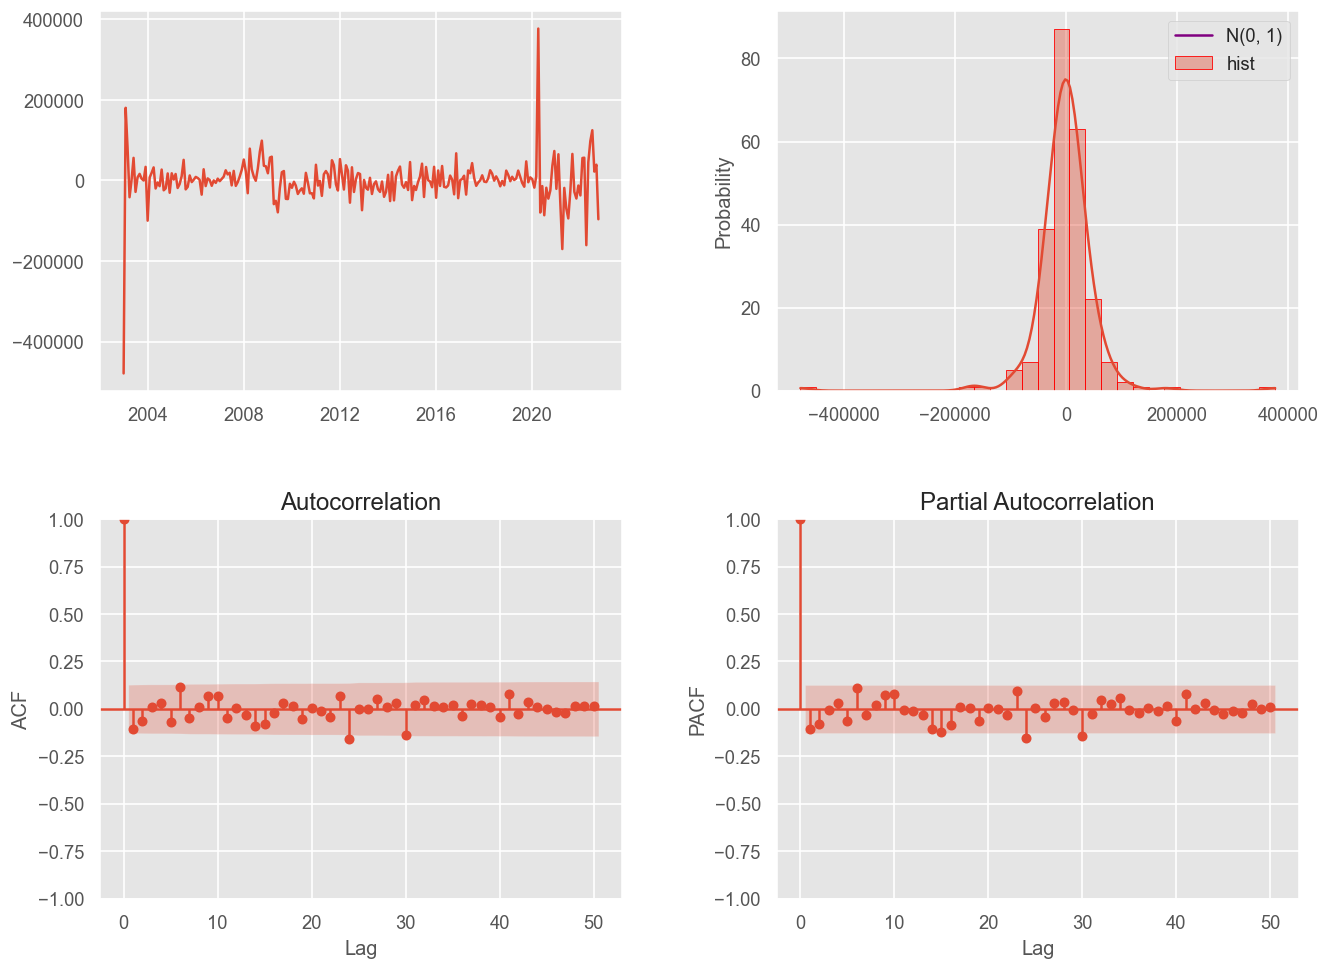

In [31]:
# Plot residual error
plt.rcParams.update({'figure.figsize': (12, 9), 'figure.dpi': 120})
FT.check_residuals(pd.DataFrame(res_sarimax.resid.loc["2003-01-01":]),lags=50)

Podemos pintar los graficos de ACF y PACF de forma independiente para poder observarlos con mayor detalle

C:\Users\Enrique\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


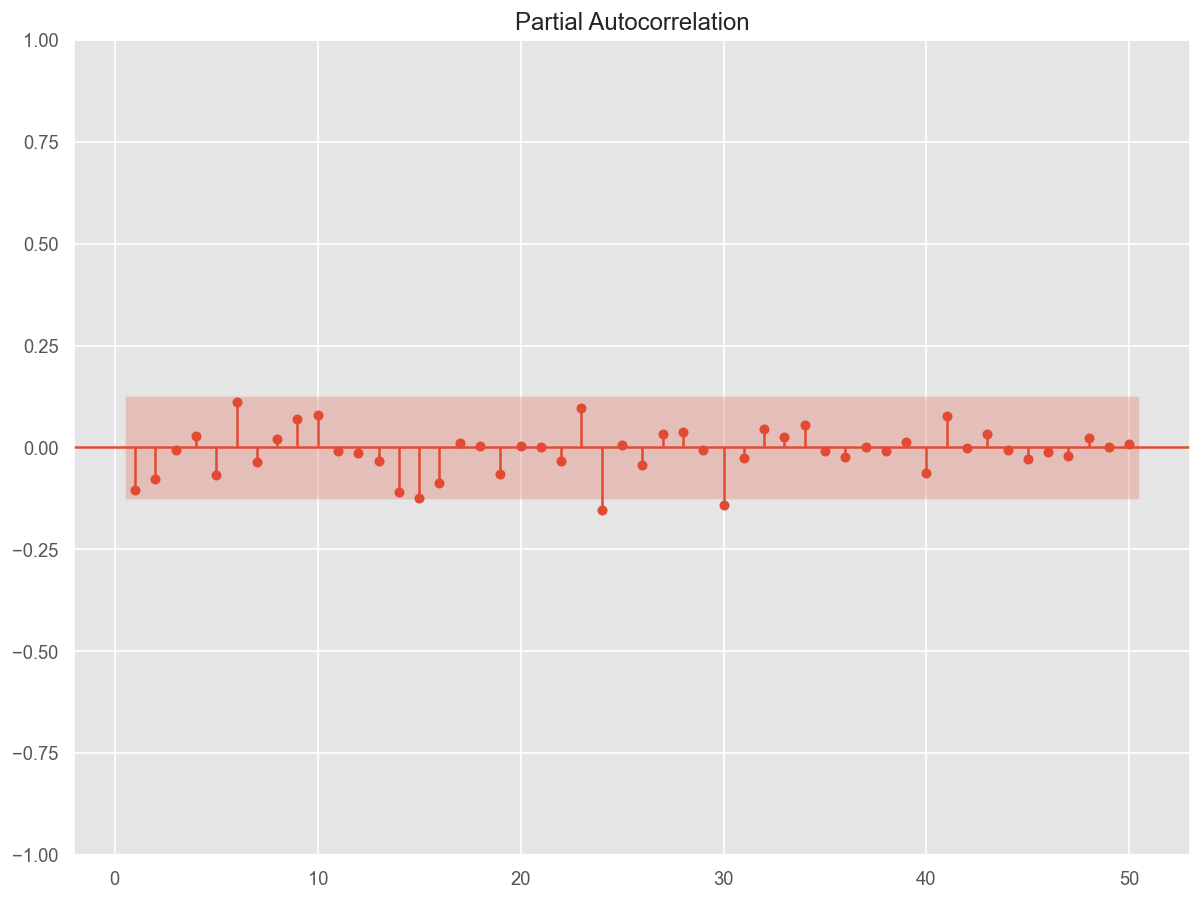

<Figure size 1440x1080 with 0 Axes>

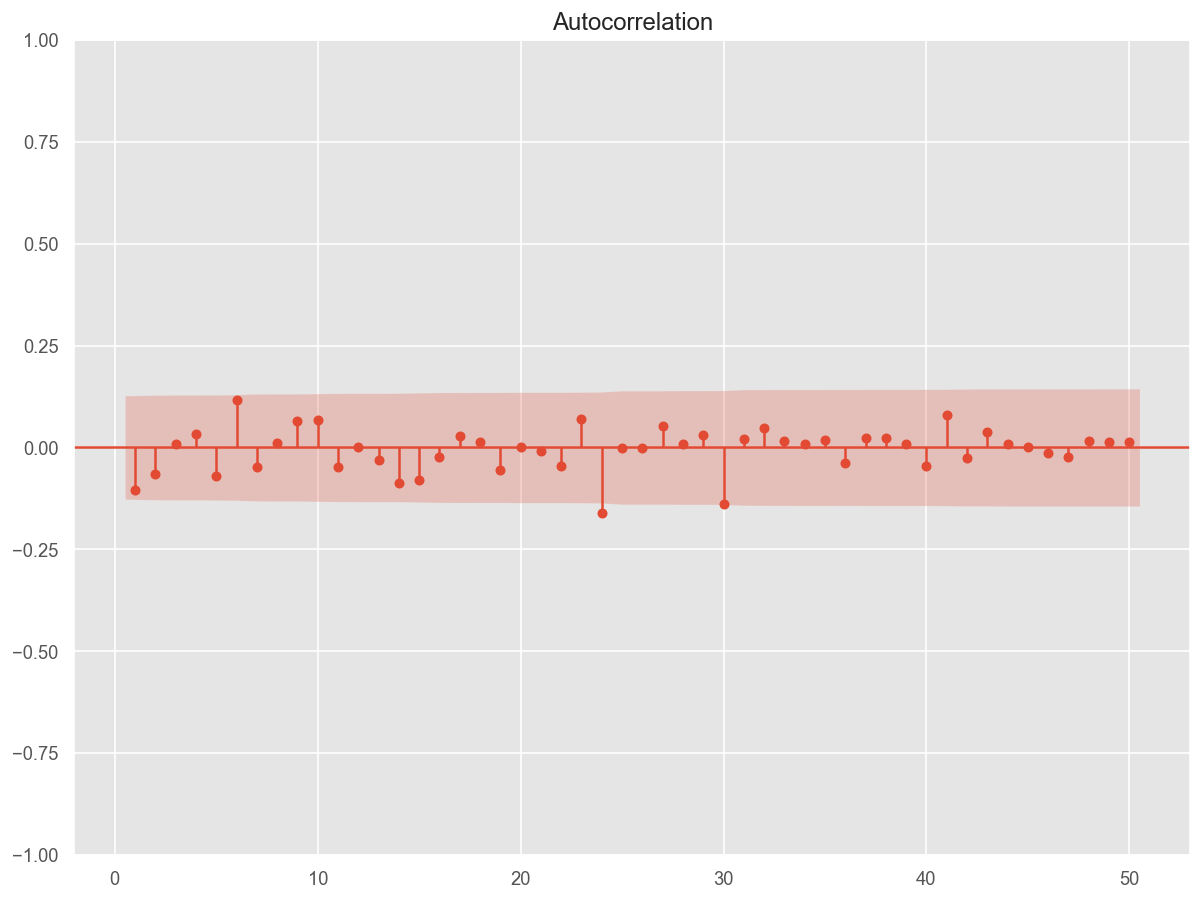

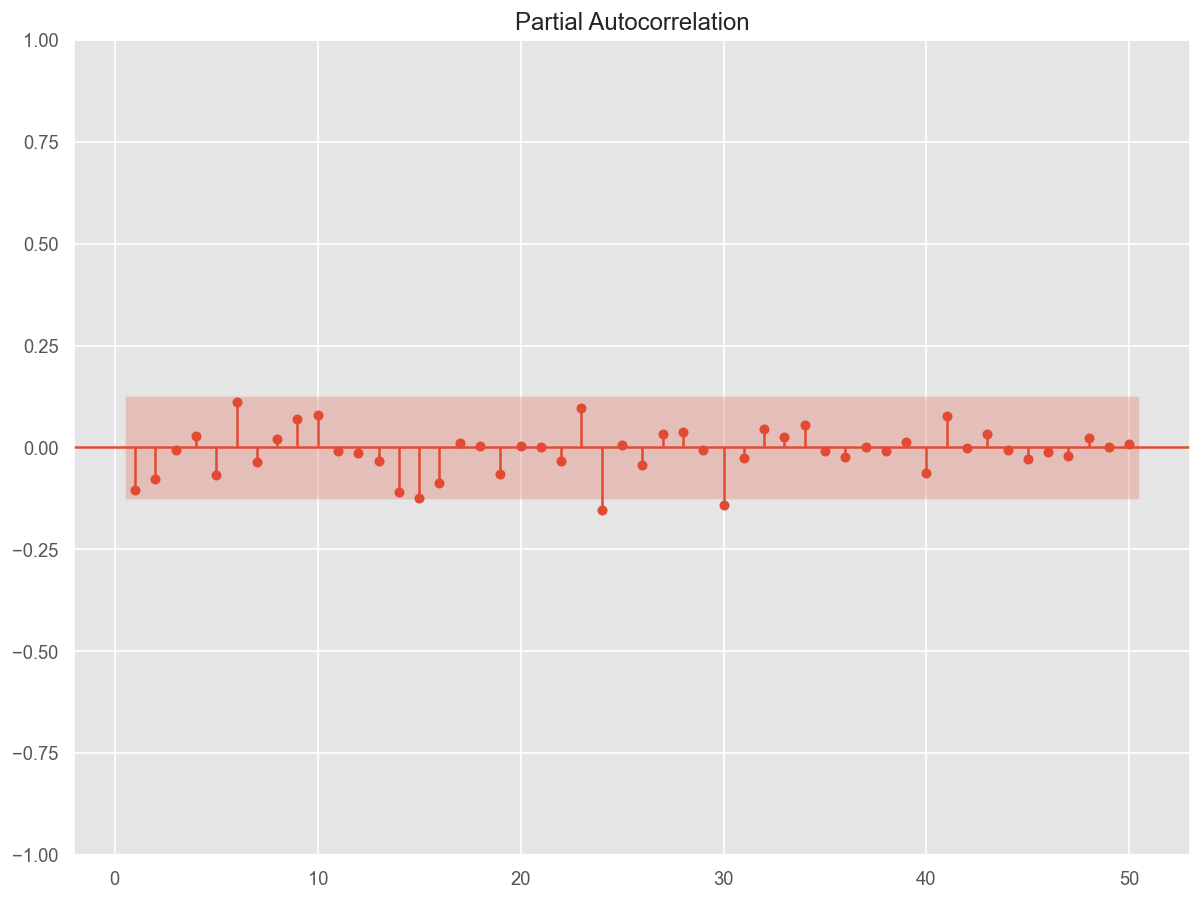

In [32]:
#Bigger plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure()
plot_acf(res_sarimax.resid.loc["2003-01-01":], lags=50,zero=False)
plot_pacf(res_sarimax.resid.loc["2003-01-01":], lags=50,zero=False)

Una vez hemos comprobador que tenemosruido blanco en nuestros residuos, podemos pasar a pintar las predicciones de nuestro modelo

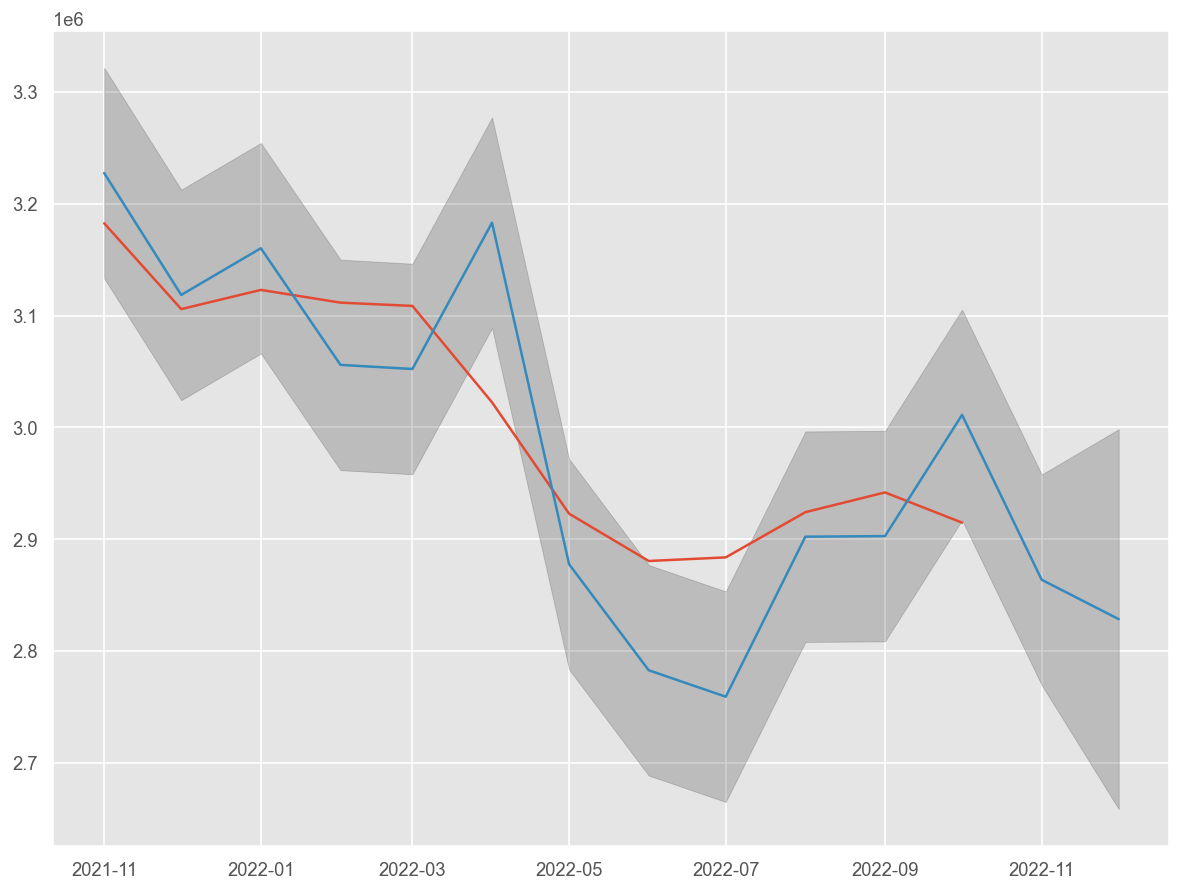

In [33]:
#Obtain forecasts for in-sample and out-of-sample
start = 250
horizon = 1
end = df_unemployment.shape[0] + horizon

pred = res_sarimax.get_prediction(start=start, 
                                    end= end, 
                                    exog = df_unemployment[INPUTS][0:2],
                                    dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

initial_date = df_unemployment.index[start]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(df_unemployment["TOTAL"].loc[initial_date:])
plt.plot(yhat)
plt.show()

In [34]:
# Ahora podemos obtener el numero de personas que predice nuestro modelo 
num_parados_noviembre = yhat.loc["2022-11-01"]
num_parados_octubre = df_unemployment.loc["2022-10-01"]["TOTAL"]
print(f"El numero de parados en octubre fue de {num_parados_octubre} personas.")
print(f"Nuestro modelo predice que el numero de parados de noviembre de 2022 es de: {num_parados_noviembre} personas")

El numero de parados en octubre fue de 2914892.0 personas.
Nuestro modelo predice que el numero de parados de noviembre de 2022 es de: 2863792.9598693918 personas


## MLP

In [90]:
dfT = pd.read_csv('UnemploymentSpain.dat',sep='\t', parse_dates=['DATE'], dayfirst=True, date_parser=dateparse, index_col='DATE')

dfT.head()

,TOTAL
DATE,
2001-01-01,2017389
2001-02-01,1993273
2001-03-01,1981006
2001-04-01,1910453
2001-05-01,1898285


In [91]:
dfT['TOTAL_lag1'] = dfT['TOTAL'].shift()
dfT['TOTAL_lag2'] = dfT['TOTAL'].shift(2)

dfT

,TOTAL,TOTAL_lag1,TOTAL_lag2
DATE,,,
2001-01-01,2017389,NaN,NaN
2001-02-01,1993273,2017389.0,NaN
2001-03-01,1981006,1993273.0,2017389.0
2001-04-01,1910453,1981006.0,1993273.0
2001-05-01,1898285,1910453.0,1981006.0
...,...,...,...
2022-06-01,2880582,2922911.0,3022503.0
2022-07-01,2883812,2880582.0,2922911.0
2022-08-01,2924240,2883812.0,2880582.0


In [92]:
# Remove missing
dfT.dropna(inplace=True)
dfT.head()

,TOTAL,TOTAL_lag1,TOTAL_lag2
DATE,,,
2001-03-01,1981006,1993273.0,2017389.0
2001-04-01,1910453,1981006.0,1993273.0
2001-05-01,1898285,1910453.0,1981006.0
2001-06-01,1842556,1898285.0,1910453.0
2001-07-01,1835738,1842556.0,1898285.0


In [39]:
# Define input and output matrices
INPUTS = ['TOTAL_lag1','TOTAL_lag2']
OUTPUT = 'TOTAL'

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = dfT[INPUTS]
y = dfT[OUTPUT]

## Divide the data into training and test sets SEQUENTIALY -------------------------------------
# Create random 80/20 % split
X_train = X.iloc[0:round(0.8*X.shape[0])]
X_test = X.iloc[round(0.8*X.shape[0])+1:X.shape[0]]
y_train = y.iloc[0:round(0.8*X.shape[0])]
y_test = y.iloc[round(0.8*X.shape[0])+1:X.shape[0]]


## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['TOTAL'] = y_train # We will call Y as output variable for simplicity
dfTS_eval = X_test.copy()
dfTS_eval['TOTAL'] = y_test # We will call Y as output variable for simplicity


X_train.head()

,TOTAL_lag1,TOTAL_lag2
DATE,,
2001-03-01,1993273.0,2017389.0
2001-04-01,1981006.0,1993273.0
2001-05-01,1910453.0,1981006.0
2001-06-01,1898285.0,1910453.0
2001-07-01,1842556.0,1898285.0


In [40]:
## Inputs of the model. 
INPUTS_NUM = ['TOTAL_lag1','TOTAL_lag2']
INPUTS_CAT = []
INPUTS_MLP = INPUTS_NUM + INPUTS_CAT


param = {'MLP__alpha': [0.0001,0.001,0.01], # Initial value of regularization
         'MLP__hidden_layer_sizes':[(5,),(13,),(20,),(25,)]} # Number of neurons in each hidden layer, enters as tuples

## Uncomment the two following lines for training a single model
#param = {'MLP__alpha': [0.0001], # Initial value of regularization
        # 'MLP__hidden_layer_sizes':[(10,)]} # Number of neurons in each hidden layer, enters as tuples

    
#### Scale data previous to fit and oneHOT
# Prepare numeric variables by scaling values
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
# Prepare the categorical variables by encoding the categories
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_NUM),
        ('cat', categorical_transformer, INPUTS_CAT)
        ])
pipe = Pipeline(steps=[('preprocessor',preprocessor), # Preprocess the variables when training the model 
                       ('MLP', MLPRegressor(solver='lbfgs', # Update function
                                             activation='relu', # Logistic sigmoid activation function
                                             #alpha=0.0001, # L2 regularization term
                                             #learning_rate='adaptive', # Type of learning rate used in training
                                             max_iter=450, # Maximum number of iterations
                                             #batch_size=10, # Size of batch when training
                                             #tol=1e-4, # Tolerance for the optimization
                                             #n_iter_no_change=10, # Maximum number of epochs to not meet tol improvement
                                             random_state=150, # For replication
                                             verbose = True))]) #Print progress

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
MLP_lagged_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='neg_mean_squared_error', # RMSE https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
MLP_lagged_fit.fit(X_train[INPUTS_MLP], y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['TOTAL_lag1',
                                                                          'TOTAL_lag2']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         [])])),
                                       ('MLP',
                                        MLPRegressor(max_iter=450,
                                                     random_state=150,
                                                     solver='lbfgs',
                                                     verbose=True))]),
             n_jobs=-1,
             param_grid={'MLP__alpha': [0.0001, 0.001, 0.01],
                         'MLP__hidden_layer_sizes': [(5,), (13,), (20,),
                                                     (25,)]},
             scoring='neg_mean_squared_error')

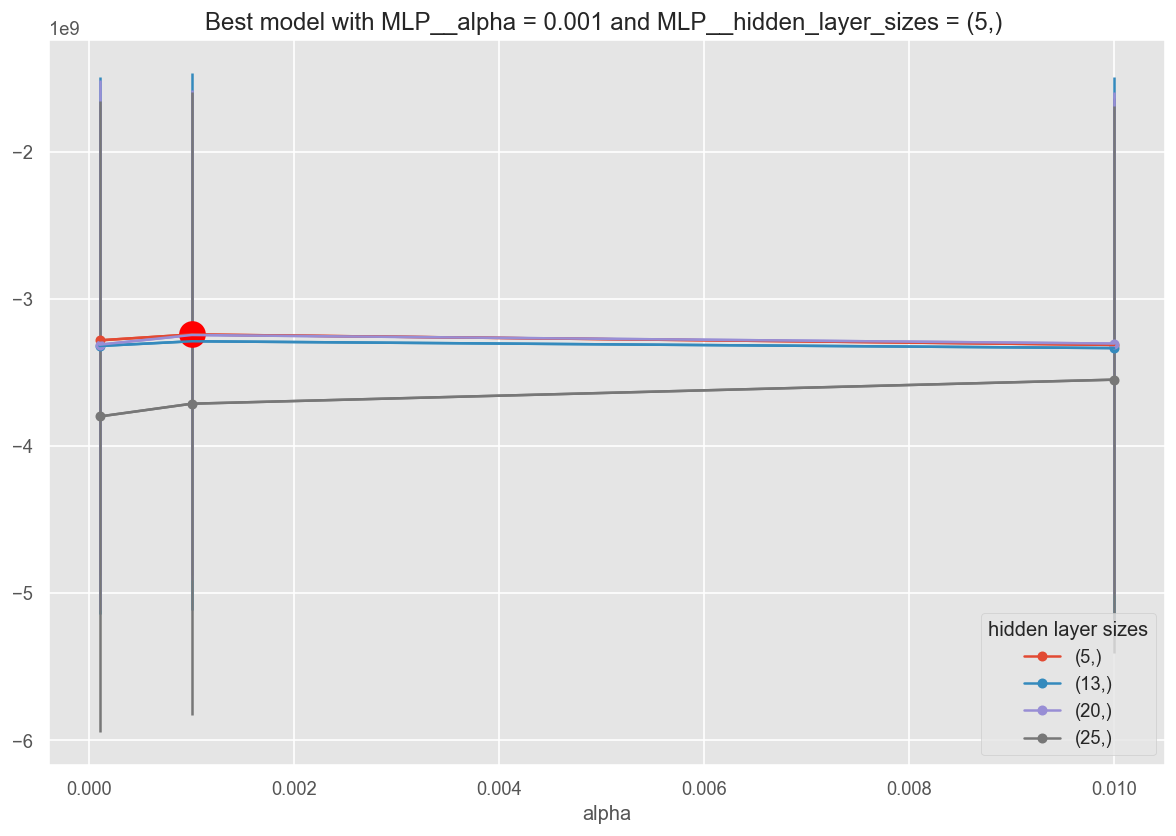

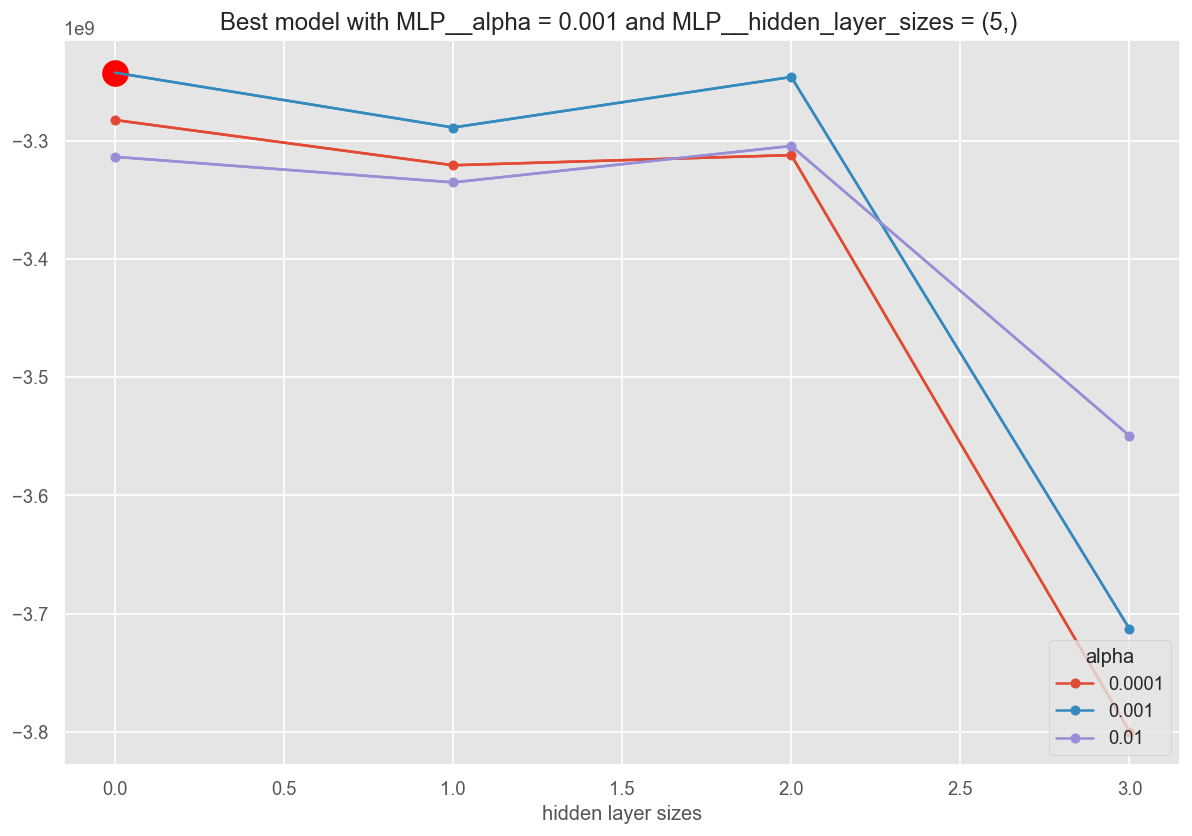

In [41]:
MT.plotModelGridError(MLP_lagged_fit)

In [42]:
mlp = MLP_lagged_fit.best_estimator_['MLP']
wts = mlp.coefs_
bias = mlp.intercepts_
actfunc = ['identity',MLP_lagged_fit.best_estimator_['MLP'].get_params()['activation'],mlp.out_activation_]
X = MLP_lagged_fit.best_estimator_['preprocessor'].transform(X_train) # Preprocess the variables
coefnames = X_train.columns.values.tolist()
X = pd.DataFrame(X, columns=coefnames)
y = pd.DataFrame(y_train, columns=['DEM'])
sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True

In [43]:
sensmlp = ns.jacobian_mlp(wts, bias, actfunc, X, y)

In [44]:
sensmlp.summary()

Sensitivity analysis of [2, 5, 1] MLP network.

Sensitivity measures of each output:

$DEM 

                    mean            std  mean_squared
TOTAL_lag1  1.656162e+06  110184.738167  1.659824e+06
TOTAL_lag2 -6.288198e+05    8423.160152  6.288763e+05


In [45]:
sensmlp.info()

Sensitivity analysis of [2, 5, 1] MLP network.

208 samples

Sensitivities of each output (only 5 first samples):

$DEM 

     TOTAL_lag1     TOTAL_lag2
0  1.562099e+06 -637367.460901
1  1.562099e+06 -637367.460901
2  1.562099e+06 -637367.460901
3  1.562099e+06 -637367.460901
4  1.562099e+06 -637367.460901


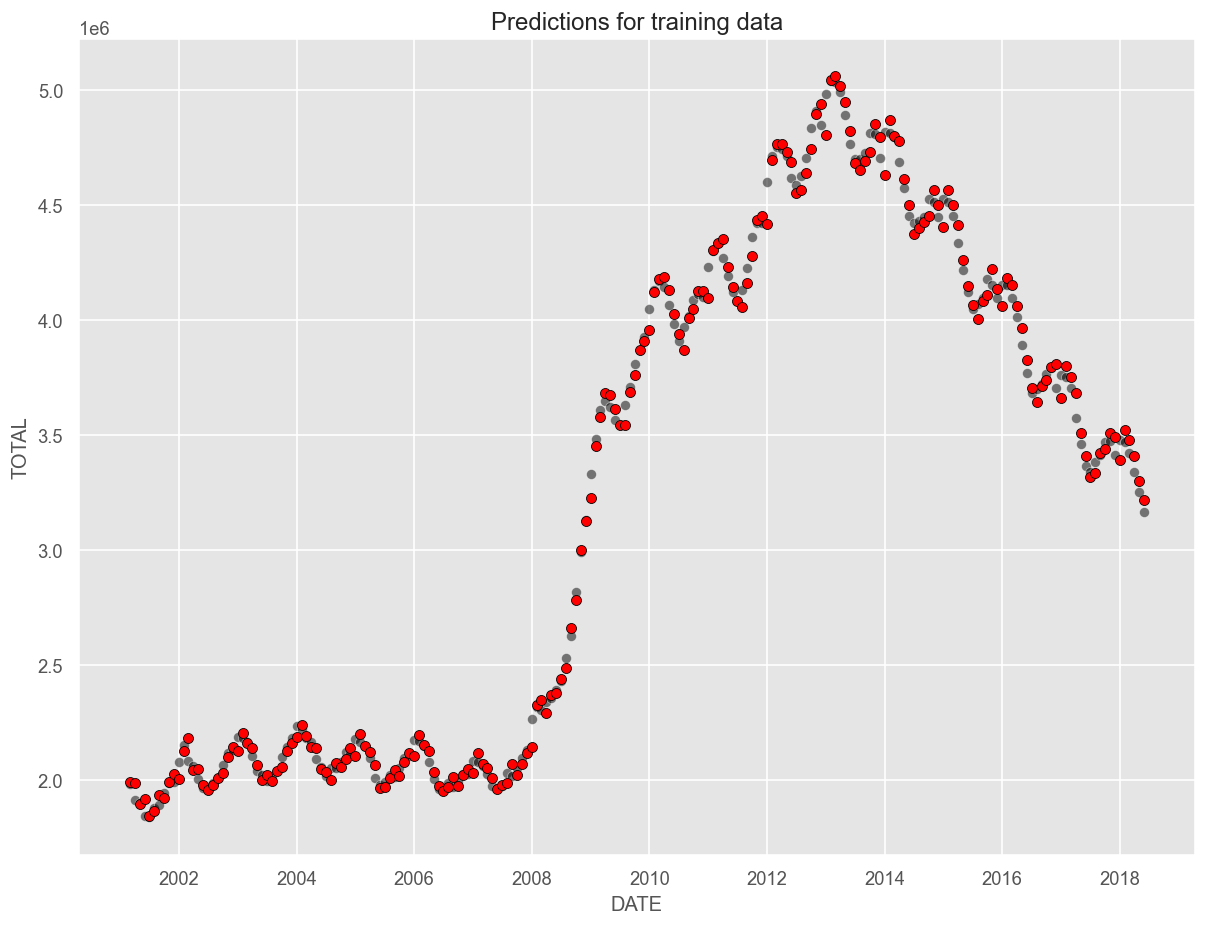

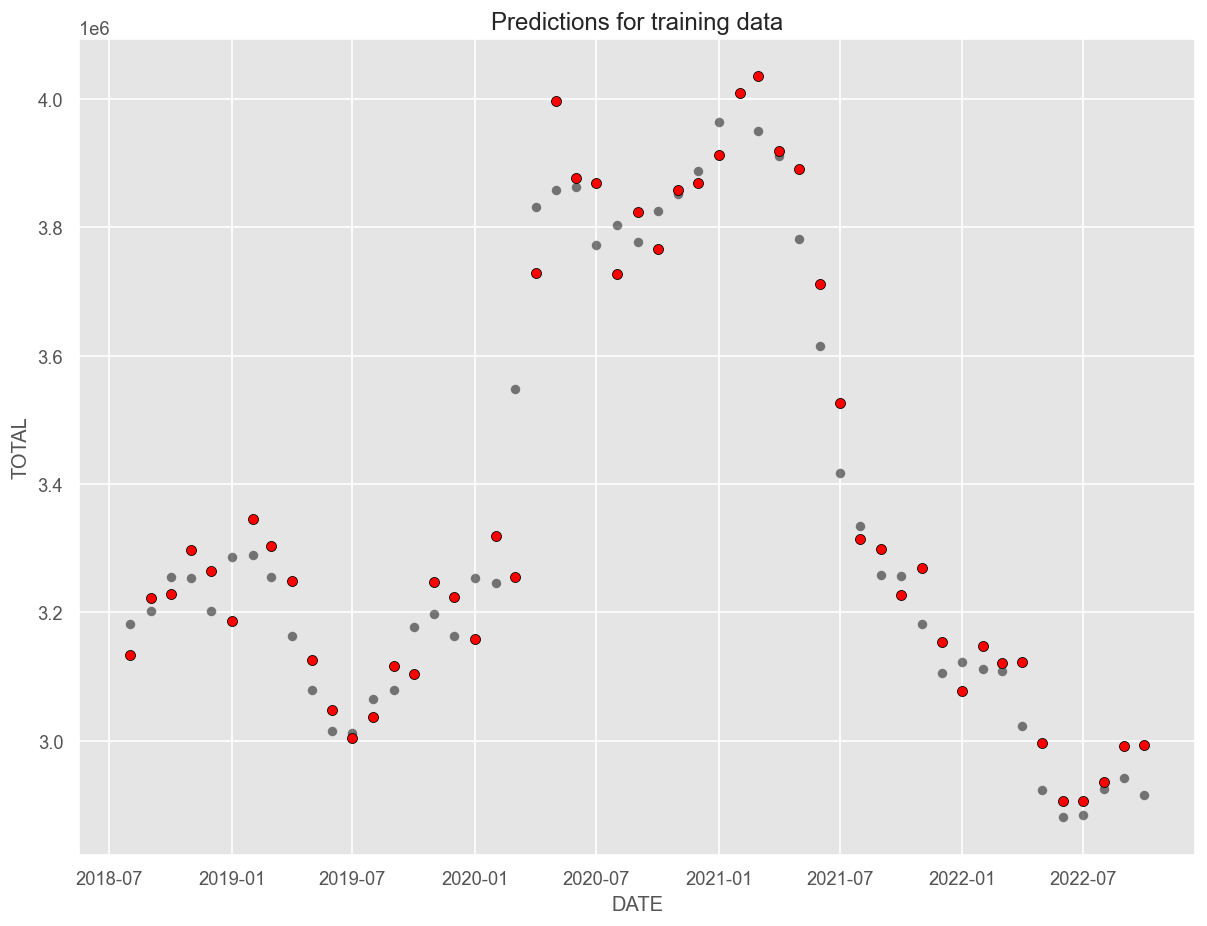

In [47]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['MLP_lagged_pred'] = MLP_lagged_fit.predict(X_train)
### Scale test using preprocess in training
dfTS_eval['MLP_lagged_pred'] = MLP_lagged_fit.predict(X_test)

### Plot predictions of the model
sns.scatterplot(x='DATE', y='TOTAL', data=dfTR_eval, color='black', alpha=0.5)
sns.scatterplot(x='DATE', y='MLP_lagged_pred', data=dfTR_eval, color='red', edgecolor='black').set_title('Predictions for training data')
plt.show()
plt.figure() # Needed to plot two separated plots instead of two overlapped
sns.scatterplot(x='DATE', y='TOTAL', data=dfTS_eval, color='black', alpha=0.5)
sns.scatterplot(x='DATE', y='MLP_lagged_pred', data=dfTS_eval, color='red', edgecolor='black').set_title('Predictions for training data')
plt.show()

In [49]:
#Training and test errors
print('Training MAE:',mean_absolute_error(dfTR_eval['TOTAL'], dfTR_eval['MLP_lagged_pred']))
print('Test MAE:',mean_absolute_error(dfTS_eval['TOTAL'], dfTS_eval['MLP_lagged_pred']))
#Training and test errors
print('Training RMSE:',math.sqrt(mean_squared_error(dfTR_eval['TOTAL'], dfTR_eval['MLP_lagged_pred'])))
print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval['TOTAL'], dfTS_eval['MLP_lagged_pred'])))
#Training and test r^2 
print('Training R2:',r2_score(dfTR_eval['TOTAL'], dfTR_eval['MLP_lagged_pred']))
print('Test R2:',r2_score(dfTS_eval['TOTAL'], dfTS_eval['MLP_lagged_pred']))

Training MAE: 40312.4029662509
Test MAE: 58648.673481329046
Training RMSE: 51948.070039084276
Test RMSE: 74873.28316238547
Training R2: 0.9977031002638578
Test R2: 0.9531989688396403


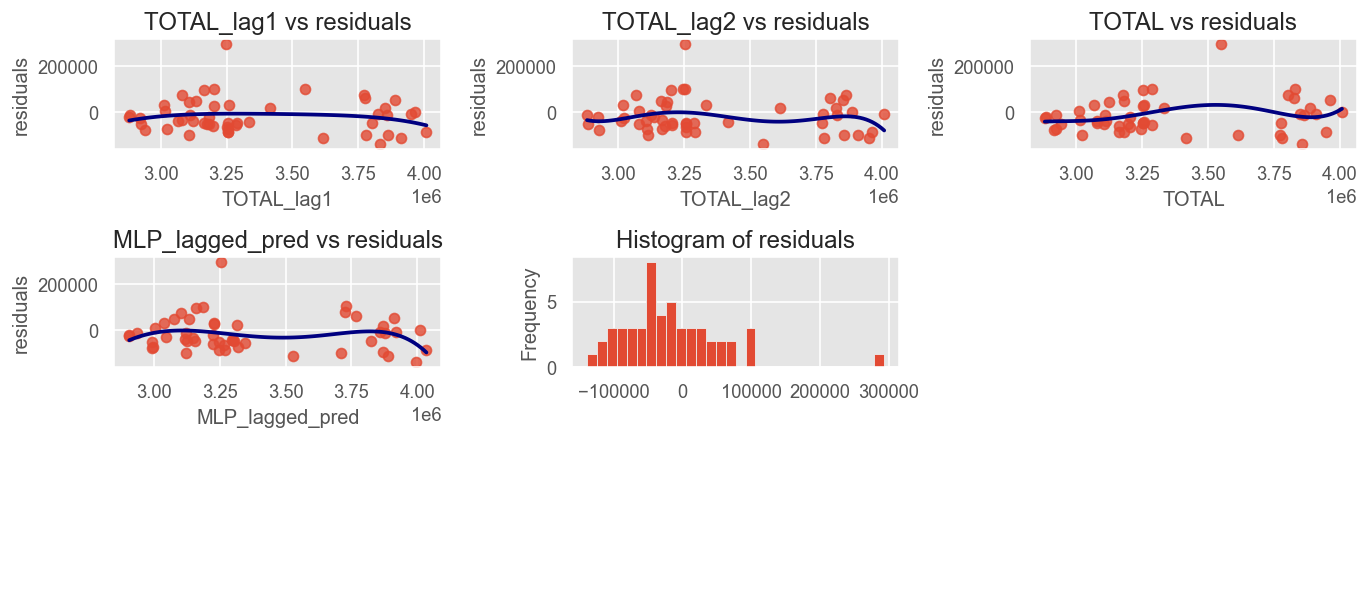

In [51]:
RT.plotModelDiagnosis(dfTS_eval, 'MLP_lagged_pred', 'TOTAL')

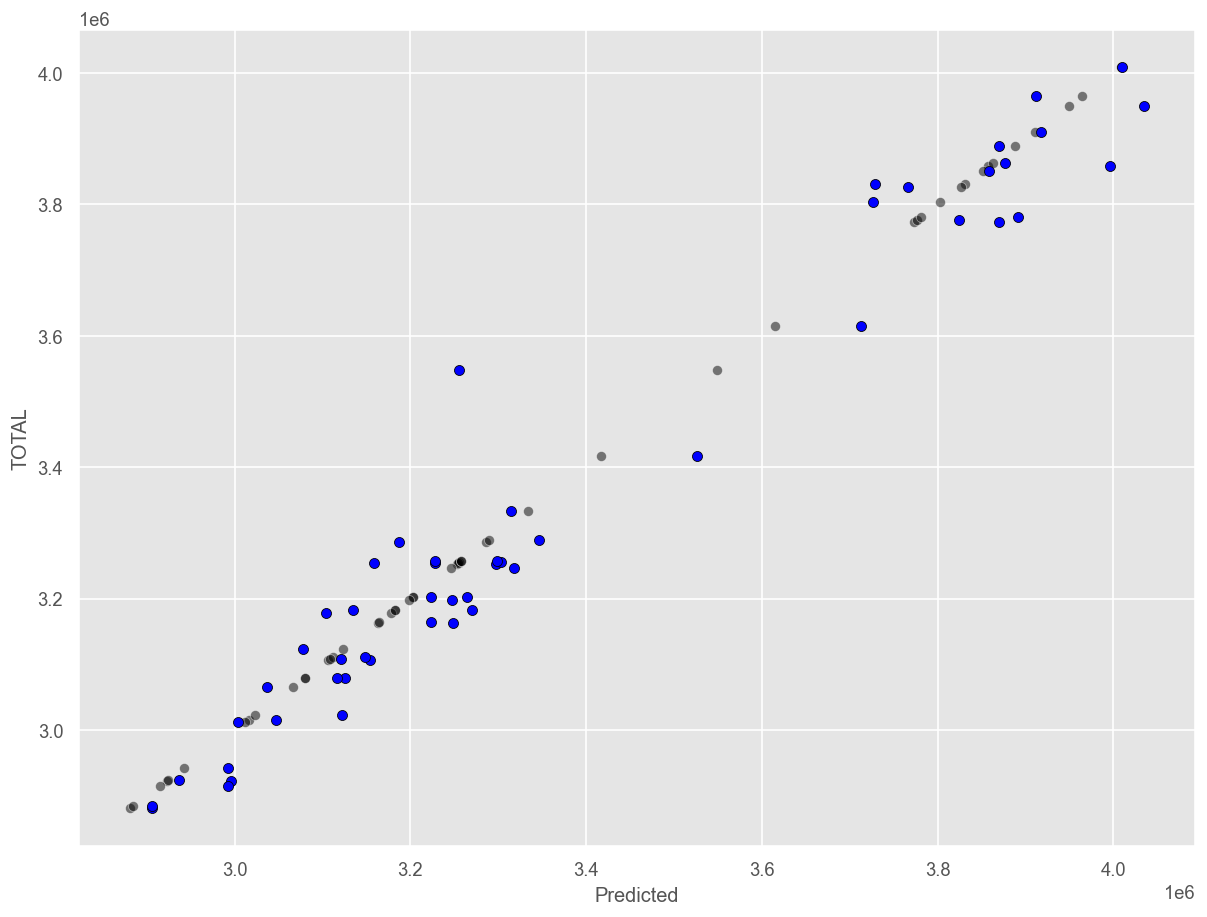

In [52]:
# Visualize prediction with respect to temperature
sns.scatterplot(data=dfTS_eval, x='TOTAL', y='TOTAL', color='black', alpha=0.5)
sns.scatterplot(data=dfTS_eval, x='MLP_lagged_pred', y='TOTAL', color='blue', edgecolor='black')
plt.xlabel('Predicted')
plt.show()

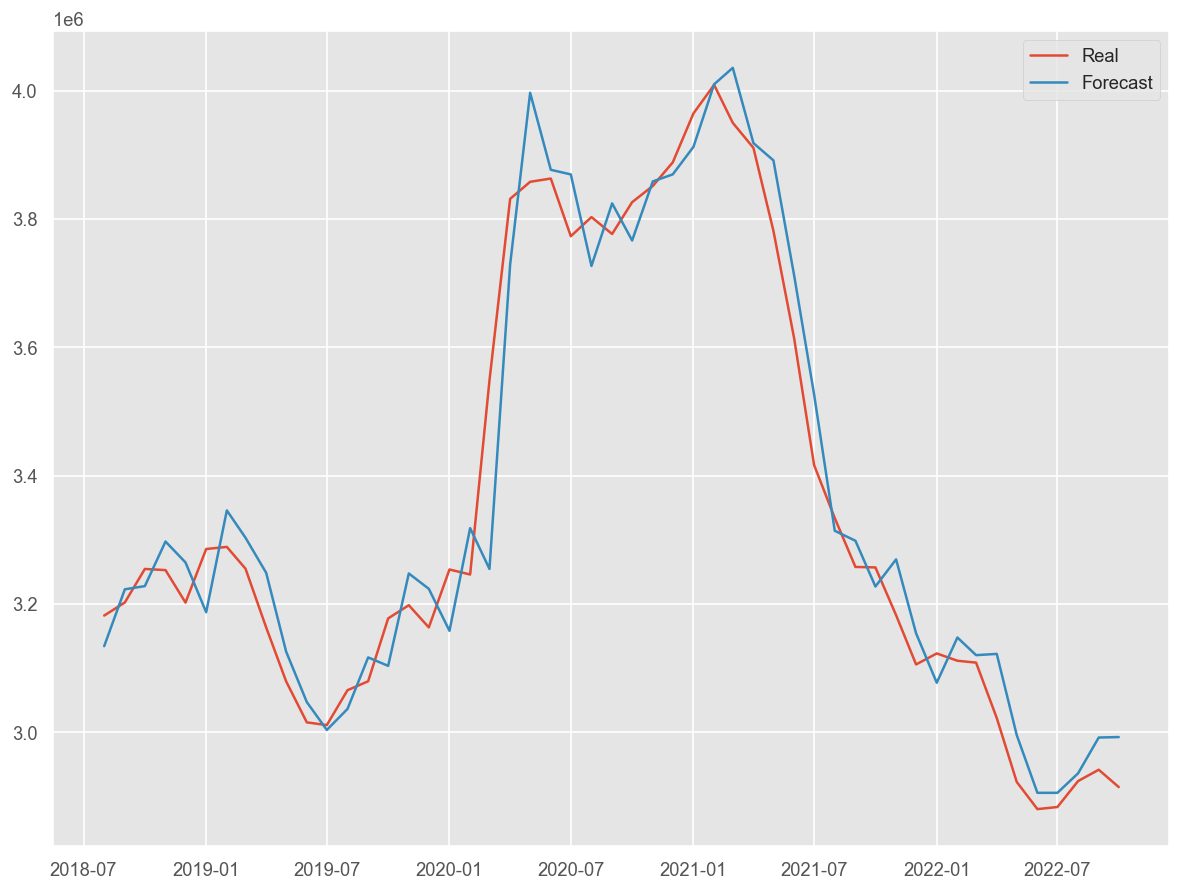

In [53]:
#Compare forecasts in time
plt.figure()
plt.plot('TOTAL', data=dfTS_eval, label='Real')
plt.plot('MLP_lagged_pred', data=dfTS_eval, label='Forecast')
plt.legend()
plt.show()

In [80]:
# Obtenemos las predicciones de todos los dias
start = 0
horizon = 1 # El mes siguiente
end = df_unemployment["TOTAL"].shape[0] + horizon

pred = MLP_lagged_fit.predict(dfT)
#print(len(pred))
#print(pred)

In [81]:
new_df= pd.DataFrame(pred)
len(new_df)

260

In [82]:
columnas = ['TOTAL', 'TOTAL_lag1', 'TOTAL_lag2']
valores = [0, 2914892.0, 2941919.0]
predic_df = pd.DataFrame([valores], columns=columnas)
predic_df

,TOTAL,TOTAL_lag1,TOTAL_lag2
0,0,2914892.0,2941919.0


In [83]:
#Obtenemos prediccion para noviembre
pred = MLP_lagged_fit.predict(predic_df)
print(pred)

[2943437.42614775]


In [84]:
valores_append = [2943437]
valor_pred_df = pd.DataFrame(valores_append)
new_df2 = pd.concat([new_df, valor_pred_df], ignore_index=True)
# !No descomentar linea de abajo! se vuelve a descargar el csv desde 0 y es un conazo poner fechas!
# new_df2.to_csv('predicciones.csv', index=False)

In [85]:
new_df2 = pd.read_csv('predicciones.csv',sep=',', parse_dates=['Date'], dayfirst=True, date_parser=dateparse, index_col='Date')
new_df2

,TOTAL
Date,
2001-05-01,1990033.033
2001-06-01,1986504.598
2001-07-01,1892309.902
2001-08-01,1916066.090
2001-09-01,1843111.432
...,...
2022-07-01,2995872.205
2022-08-01,2905951.307
2022-09-01,2905954.728


In [93]:
dfT = dfT.iloc[2:]
dfT

,TOTAL,TOTAL_lag1,TOTAL_lag2
DATE,,,
2001-05-01,1898285,1910453.0,1981006.0
2001-06-01,1842556,1898285.0,1910453.0
2001-07-01,1835738,1842556.0,1898285.0
2001-08-01,1878513,1835738.0,1842556.0
2001-09-01,1889185,1878513.0,1835738.0
...,...,...,...
2022-06-01,2880582,2922911.0,3022503.0
2022-07-01,2883812,2880582.0,2922911.0
2022-08-01,2924240,2883812.0,2880582.0


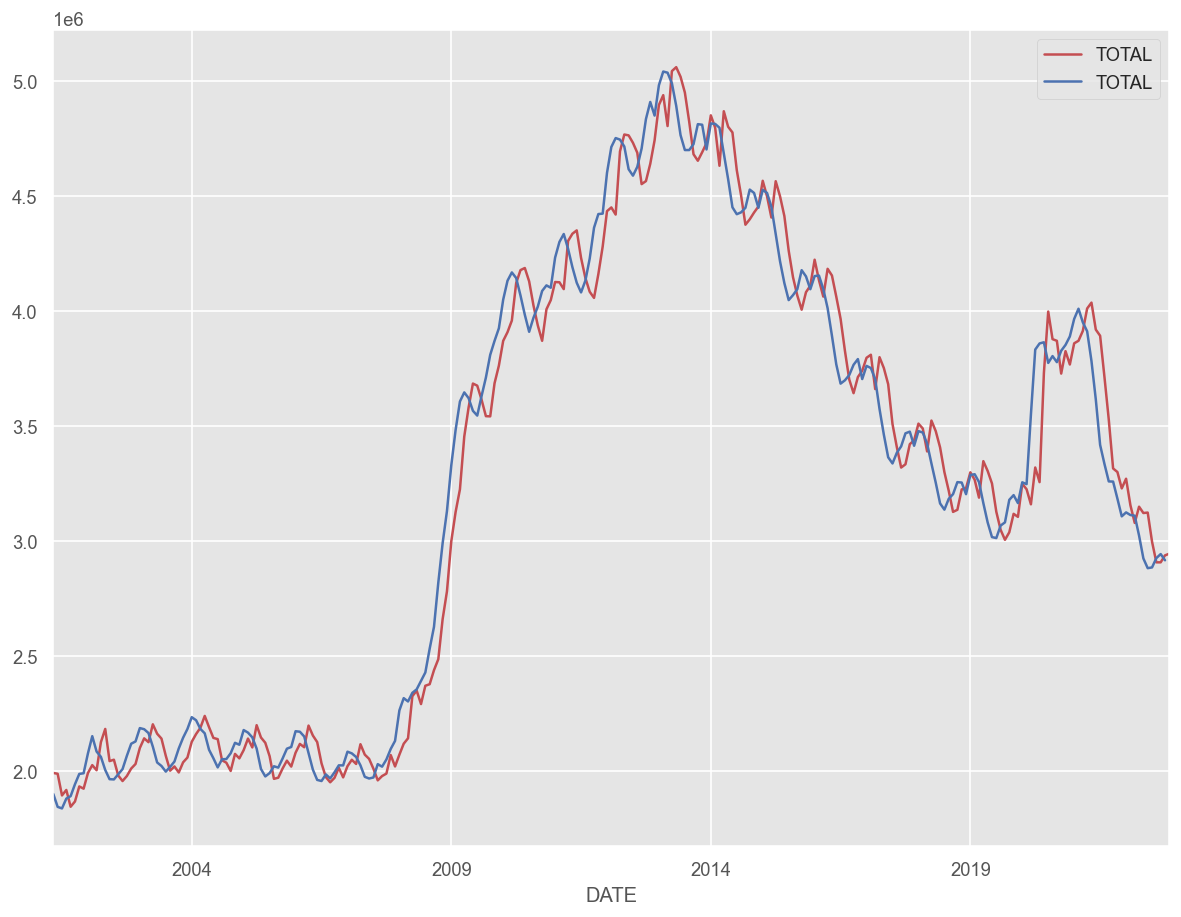

In [94]:
import matplotlib.pyplot as plt
new_df2.plot(color='r')
dfT['TOTAL'].plot(color='b')
plt.legend()
plt.show()

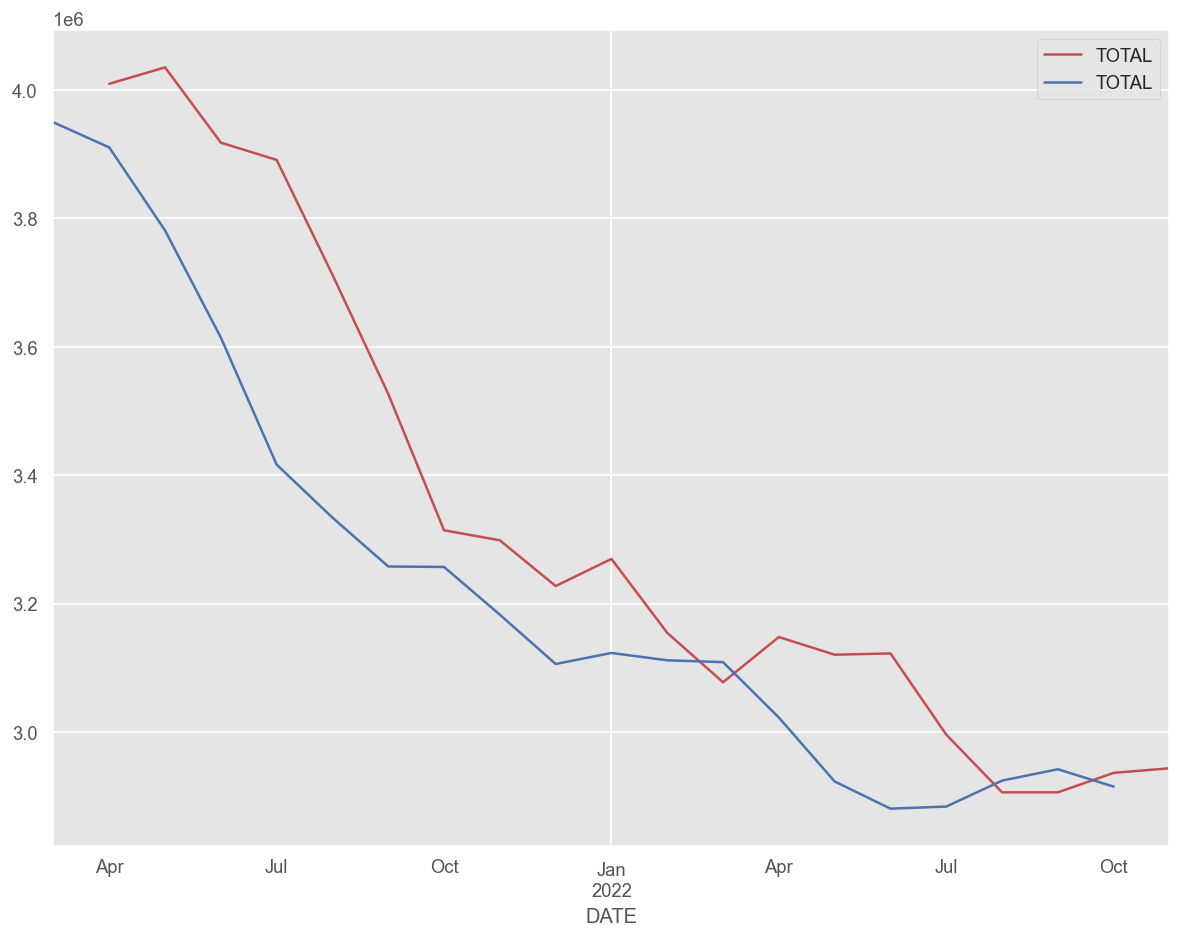

In [95]:
import matplotlib.pyplot as plt
new_df2.iloc[-20:].plot(color='r')
dfT['TOTAL'].iloc[-20:].plot(color='b')
plt.legend()
plt.show()

In [99]:
print(f"La prediccion de paro para el mes de noviembre es de: {int(pred[0])}")

La prediccion de paro para el mes de noviembre es de: 2943437
